In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from pathlib import Path
import string
import re
import joblib
import json
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [2]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [3]:
def load_doc(jsonFile):
    with open(jsonFile) as file:
        Json_data = json.loads(file.read())
    return Json_data

In [4]:
data = load_doc('intents.json')

In [5]:
def frame_data(feat_1,feat_2,is_pattern):
    is_pattern = is_pattern
    df = pd.DataFrame(columns=[feat_1,feat_2])
    for intent in data['intents']:
        if is_pattern:
            for pattern in intent['patterns']:
                w = pattern
                df_to_append = pd.Series([w,intent['tag']], index = df.columns)
                df = df.append(df_to_append,ignore_index=True)
        else:
            for response in intent['responses']:
                w = response
                df_to_append = pd.Series([w,intent['tag']], index = df.columns)
                df = df.append(df_to_append,ignore_index=True)
    return df

In [6]:
# users intents 
df1 = frame_data('questions','labels',True)
df1

,questions,labels
0,Hi there,start_conversation
1,Is anyone there?,start_conversation
2,Hey,start_conversation
3,Hola,start_conversation
4,Hello,start_conversation
...,...,...
73,How is extras counted?,scoring
74,what are the extras rules,scoring
75,How is cricket extras counted?,scoring
76,Explain extras board,scoring


In [7]:
df1.labels.value_counts(sort=False)

scoring                5
first_server           6
bot_scope              5
general_rules          5
what_are_you           4
ground_lines           3
thanks                 5
tie_break              5
start_conversation     7
end_conversation       5
kits                  10
cricket_games          4
options                8
top_players            6
Name: labels, dtype: int64

In [8]:
# Bot response
df2 = frame_data('response','labels',False)
df2.head()

,response,labels
0,"Hello, I'm sure you love Cricket",start_conversation
1,Happy to have you here,start_conversation
2,Good to see you again,start_conversation
3,"Hi there, how can I help?",start_conversation
4,"Hi, I'm CricBot",what_are_you


In [9]:
lemmatizer = WordNetLemmatizer()

vocab = Counter()
labels = []
def tokenizer(entry):
    tokens = entry.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    tokens = [re_punc.sub('', w) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [lemmatizer.lemmatize(w.lower()) for w in tokens]
#     stop_words = set(stopwords.words('english'))
#     tokens = [w for w in tokens if not w in stop_words]
    tokens = [word.lower() for word in tokens if len(word) > 1]
    return tokens

In [10]:
def remove_stop_words(tokenizer,df,feature):
    doc_without_stopwords = []
    for entry in df[feature]:
        tokens = tokenizer(entry)
        joblib.dump(tokens,'tokens.pkl')
        doc_without_stopwords.append(' '.join(tokens))
    df[feature] = doc_without_stopwords
    return 

In [11]:
def create_vocab(tokenizer,df,feature):
    for entry in df[feature]:
        tokens = tokenizer(entry)   
        vocab.update(tokens)
    joblib.dump(vocab,'vocab.pkl')
    return 

In [12]:
create_vocab(tokenizer,df1,'questions')
remove_stop_words(tokenizer,df1,'questions')

In [13]:
print(vocab.most_common(20))

[('cricket', 34), ('you', 22), ('the', 22), ('what', 21), ('are', 15), ('do', 14), ('how', 8), ('in', 8), ('can', 7), ('know', 7), ('is', 6), ('about', 6), ('player', 6), ('list', 6), ('rule', 6), ('who', 5), ('kit', 5), ('wear', 5), ('game', 5), ('extra', 5)]


In [14]:
vocab_size = len(vocab)
vocab_size

108

In [15]:
df1

,questions,labels
0,hi there,start_conversation
1,is anyone there,start_conversation
2,hey,start_conversation
3,hola,start_conversation
4,hello,start_conversation
...,...,...
73,how is extra counted,scoring
74,what are the extra rule,scoring
75,how is cricket extra counted,scoring
76,explain extra board,scoring


In [16]:
test_list = list(df1.groupby(by='labels',as_index=False).first()['questions'])
test_list

['what do you know about cricket',
 'do you know cricket game format',
 'bye',
 'who bat first',
 'what are the general rule of cricket',
 'each line on the cricket ground mean whats',
 'what are the cricket kit need to get started',
 'how can you help me',
 'how is extra counted',
 'hi there',
 'thanks',
 'what will happen if game end in same score',
 'who are the top player in cricket',
 'what is your name']

In [55]:
test_index = []
for i,_ in enumerate(test_list):
    idx = df1[df1.questions == test_list[i]].index[0]
    test_index.append(idx)
test_index

[29, 64, 11, 58, 40, 55, 45, 21, 73, 0, 16, 68, 34, 7]

In [56]:
train_index = [i for i in df1.index if i not in test_index]

In [58]:
train_index = train_index[:-1]
train_index

[1,
 2,
 3,
 4,
 5,
 6,
 8,
 9,
 10,
 12,
 13,
 14,
 15,
 17,
 18,
 19,
 20,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 30,
 31,
 32,
 33,
 35,
 36,
 37,
 38,
 39,
 41,
 42,
 43,
 44,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 56,
 57,
 59,
 60,
 61,
 62,
 63,
 65,
 66,
 67,
 69,
 70,
 71,
 72,
 74,
 75,
 76]

In [19]:
' '.join(list(vocab.keys()))

'hi there is anyone hey hola hello good day what your name are you who pls bye see later goodbye nice chatting to till next time thanks thank thats helpful awesome for helping me how can help do provide be support offered know about cricket tell really lot exactly mean by guide through the top player in list best general rule of playing kit need get started wear beginner full will each line on ground whats why so many where base bat first decide or field anybody game format different explain type happen if end same score tiebreak doe work winner when tie break extra counted board count'

In [20]:
def encoder(df,feature):
#     text = ' '.join(list(vocab.keys()))
    t = Tokenizer()
    entries = [entry for entry in df[feature]]
    t.fit_on_texts(entries)
    joblib.dump(t,'tokenizer_t.pkl')
    vocab_size = len(t.word_index) + 1
    entries = [entry for entry in df[feature]]
    max_length = max([len(s.split()) for s in entries])
    encoded = t.texts_to_sequences(entries)
    padded = pad_sequences(encoded, maxlen=max_length, padding='post')
    return padded, vocab_size

In [21]:
X,vocab_size = encoder(df1,'questions')

In [22]:
df_encoded = pd.DataFrame(X)

In [23]:
df_encoded['labels'] = df1.labels
df_encoded.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,labels
0,40,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,start_conversation
1,11,59,28,0,0,0,0,0,0,0,0,0,0,0,0,0,start_conversation
2,60,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,start_conversation
3,61,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,start_conversation
4,62,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,start_conversation


In [24]:
for i in range(0,2):
    dt = [0]*16
    dt.append('confused')
    dt = [dt]
    pd.DataFrame(dt).rename(columns = {16:'labels'})
    df_encoded = df_encoded.append(pd.DataFrame(dt).rename(columns = {16:'labels'}),ignore_index=True)

In [25]:
df_encoded.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,labels
75,7,11,1,20,58,0,0,0,0,0,0,0,0,0,0,0,scoring
76,54,20,107,0,0,0,0,0,0,0,0,0,0,0,0,0,scoring
77,7,6,2,108,1,20,0,0,0,0,0,0,0,0,0,0,scoring
78,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,confused
79,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,confused


In [26]:
train_index.append(87)

In [27]:
test_index.append(88)

In [28]:
# df_encoded = df_encoded.append(pd.DataFrame(dt).rename(columns = {16:'labels'}),ignore_index=True)

In [29]:
from sklearn.preprocessing import LabelEncoder
lable_enc = LabelEncoder()

In [30]:
labl = lable_enc.fit_transform(df_encoded.labels)
labl

array([10, 10, 10, 10, 10, 10, 10, 14, 14, 14, 14,  3,  3,  3,  3,  3, 11,
       11, 11, 11, 11,  8,  8,  8,  8,  8,  8,  8,  8,  0,  0,  0,  0,  0,
       13, 13, 13, 13, 13, 13,  5,  5,  5,  5,  5,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  6,  6,  6,  4,  4,  4,  4,  4,  4,  2,  2,  2,  2,
       12, 12, 12, 12, 12,  9,  9,  9,  9,  9,  1,  1])

In [31]:
mapper = {}
for index,key in enumerate(df_encoded.labels):
    if key not in mapper.keys():
        mapper[key] = labl[index]
mapper

{'bot_scope': 0,
 'confused': 1,
 'cricket_games': 2,
 'end_conversation': 3,
 'first_server': 4,
 'general_rules': 5,
 'ground_lines': 6,
 'kits': 7,
 'options': 8,
 'scoring': 9,
 'start_conversation': 10,
 'thanks': 11,
 'tie_break': 12,
 'top_players': 13,
 'what_are_you': 14}

In [32]:
df2.head()

,response,labels
0,"Hello, I'm sure you love Cricket",start_conversation
1,Happy to have you here,start_conversation
2,Good to see you again,start_conversation
3,"Hi there, how can I help?",start_conversation
4,"Hi, I'm CricBot",what_are_you


In [33]:
df2.labels = df2.labels.map(mapper).astype({'labels': 'int32'})
df2.head()

,response,labels
0,"Hello, I'm sure you love Cricket",10
1,Happy to have you here,10
2,Good to see you again,10
3,"Hi there, how can I help?",10
4,"Hi, I'm CricBot",14


In [34]:
df2.to_csv('response.csv',index=False)

In [35]:
# df2.groupby('labels').get_group(11)

In [46]:
df_encoded

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,labels
0,40,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,start_conversation
1,11,59,28,0,0,0,0,0,0,0,0,0,0,0,0,0,start_conversation
2,60,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,start_conversation
3,61,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,start_conversation
4,62,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,start_conversation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,7,11,1,20,58,0,0,0,0,0,0,0,0,0,0,0,scoring
76,54,20,107,0,0,0,0,0,0,0,0,0,0,0,0,0,scoring
77,7,6,2,108,1,20,0,0,0,0,0,0,0,0,0,0,scoring
78,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,confused


In [49]:
train_index

[1,
 2,
 3,
 4,
 5,
 6,
 8,
 9,
 10,
 12,
 13,
 14,
 15,
 17,
 18,
 19,
 20,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 30,
 31,
 32,
 33,
 35,
 36,
 37,
 38,
 39,
 41,
 42,
 43,
 44,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 56,
 57,
 59,
 60,
 61,
 62,
 63,
 65,
 66,
 67,
 69,
 70,
 71,
 72,
 74,
 75,
 76,
 77,
 87]

In [59]:
train = df_encoded.iloc[train_index,:]
test = df_encoded.iloc[test_index,:]

In [60]:
X_train = train.drop(columns=['labels'],axis=1)
y_train = train.labels
X_test = test.drop(columns=['labels'],axis=1)
y_test = test.labels

In [61]:
y_train =pd.get_dummies(y_train).values
y_test =pd.get_dummies(y_test).values

In [62]:
y_train[0].shape,y_test[0].shape

((14,), (14,))

In [63]:
X_train.shape

(63, 16)

In [64]:
max_length = X_train.shape[1]
# output = len(df3.labels.unique())
output = 17

In [65]:
# def define_model(vocab_size, max_length):
#     model = Sequential()
#     model.add(Embedding(vocab_size,300, input_length=max_length))
#     model.add(Conv1D(filters=64, kernel_size=6, activation='relu'))
#     model.add(MaxPooling1D(pool_size=4))
#     model.add(Flatten())
# #     model.add(Dense(32, activation='relu'))
#     model.add(Dense(16, activation='softmax'))
    
#     # compile network
#     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#     # summarize defined model
#     model.summary()
# #     plot_model(model, to_file='model.png', show_shapes=True)
#     return model

In [66]:
max_length

16

In [67]:
early_stopping = EarlyStopping(monitor='val_loss',patience=10)
checkpoint = ModelCheckpoint("model-v1.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, verbose = 1, min_delta = 0.0001)
callbacks = [early_stopping,checkpoint,reduce_lr]
    
    

In [71]:

def define_model(vocab_size, max_length):
    model = Sequential()
    model.add(Embedding(vocab_size,300, input_length=max_length))
    model.add(Conv1D(filters=64, kernel_size=4, activation='relu'))
    model.add(MaxPooling1D(pool_size=8))
    model.add(Flatten())
#     model.add(Dense(32, activation='relu'))
    model.add(Dense(14, activation='softmax'))
    
    
    # compile network
#     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.compile(loss = 'categorical_crossentropy',
              # optimizer = Adam(lr=0.001),
              optimizer = 'adam',
              metrics = ['accuracy'])
    
    # summarize defined model
    model.summary()
#     plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [72]:
# define model
model = define_model(vocab_size, max_length)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 16, 300)           32700     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 13, 64)            76864     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1, 64)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 14)                910       
Total params: 110,474
Trainable params: 110,474
Non-trainable params: 0
_________________________________________________________________


In [73]:
history = model.fit(X_train, y_train, epochs=500, verbose=1,validation_data=(X_test,y_test),callbacks=callbacks)

Epoch 1/500
2/2 [==============================] - 1s 359ms/step - loss: 2.6442 - accuracy: 0.0212 - val_loss: 2.6002 - val_accuracy: 0.3571

Epoch 00001: val_loss improved from inf to 2.60016, saving model to model-v1.h5
Epoch 2/500
2/2 [==============================] - 0s 64ms/step - loss: 2.5671 - accuracy: 0.4215 - val_loss: 2.5710 - val_accuracy: 0.3571

Epoch 00002: val_loss improved from 2.60016 to 2.57097, saving model to model-v1.h5
Epoch 3/500
2/2 [==============================] - 0s 73ms/step - loss: 2.5022 - accuracy: 0.5160 - val_loss: 2.5420 - val_accuracy: 0.3571

Epoch 00003: val_loss improved from 2.57097 to 2.54205, saving model to model-v1.h5
Epoch 4/500
2/2 [==============================] - 0s 69ms/step - loss: 2.4456 - accuracy: 0.5685 - val_loss: 2.5096 - val_accuracy: 0.3571

Epoch 00004: val_loss improved from 2.54205 to 2.50965, saving model to model-v1.h5
Epoch 5/500
2/2 [==============================] - 0s 70ms/step - loss: 2.3907 - accuracy: 0.5580 - val

In [73]:
history.history['val_accuracy']

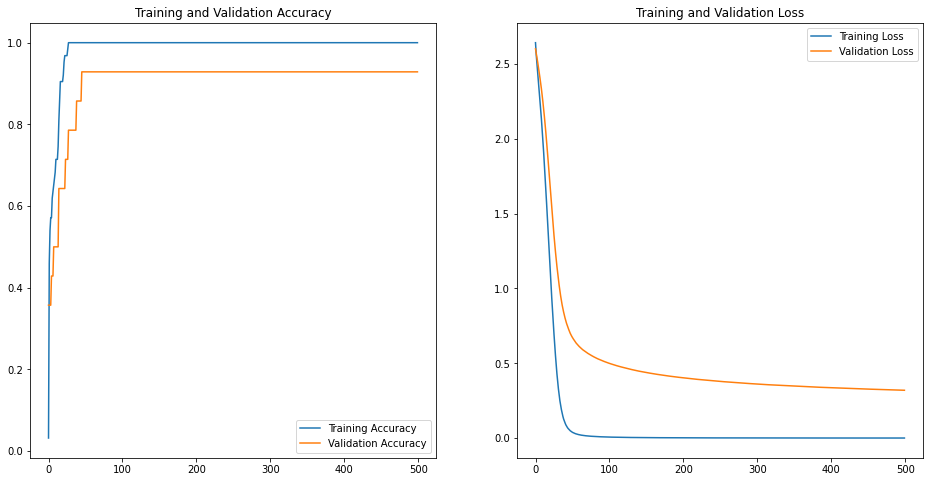

In [76]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [77]:
[np.argmax(i) for i in model.predict(X_test)][:10]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [78]:
[np.argmax(i) for i in y_test][:10]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

## New user question encoding

In [79]:
def get_text():
    input_text  = ['what are you']
    df_input = pd.DataFrame(input_text,columns=['questions'])
    df_input
    return df_input 

In [80]:
#load artifacts 
from tensorflow.keras.models import load_model
model = load_model('model-v1.h5')
tokenizer_t = joblib.load('tokenizer_t.pkl')
vocab = joblib.load('vocab.pkl')

In [81]:
def tokenizer(entry):
    tokens = entry.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    tokens = [re_punc.sub('', w) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [lemmatizer.lemmatize(w.lower()) for w in tokens]
#     stop_words = set(stopwords.words('english'))
#     tokens = [w for w in tokens if not w in stop_words]
    tokens = [word.lower() for word in tokens if len(word) > 1]
    return tokens

In [82]:
def remove_stop_words_for_input(tokenizer,df,feature):
    doc_without_stopwords = []
    entry = df[feature][0]
    tokens = tokenizer(entry)
    doc_without_stopwords.append(' '.join(tokens))
    df[feature] = doc_without_stopwords
    return df

In [83]:
# df_input = remove_stop_words_for_input(tokenizer,df_input,'questions')
# df_input

In [84]:
def encode_input_text(tokenizer_t,df,feature):
    t = tokenizer_t
    entry = entry = [df[feature][0]]
    encoded = t.texts_to_sequences(entry)
    padded = pad_sequences(encoded, maxlen=16, padding='post')
    return padded

In [85]:
# encoded_input = encode_input_text(tokenizer_t,df_input,'questions')
# encoded_input.shape

In [86]:
# encoded_input

In [87]:
def get_pred(model,encoded_input):
    pred = np.argmax(model.predict(encoded_input))
    return pred

In [88]:
# mapper

In [89]:
# df2.head()

In [90]:
def bot_precausion(df_input,pred):
    words = df_input.questions[0].split()
    if len([w for w in words if w in vocab])==0 :
        pred = 1
    return pred

In [91]:
def get_response(df2,pred):
    upper_bound = df2.groupby('labels').get_group(pred).shape[0]
    r = np.random.randint(0,upper_bound)
    responses = list(df2.groupby('labels').get_group(pred).response)
    return responses[r]
    

In [92]:
def bot_response(response,):
    print(response)

In [93]:
df_input = get_text()

#load artifacts 
tokenizer_t = joblib.load('tokenizer_t.pkl')
vocab = joblib.load('vocab.pkl')

df_input = remove_stop_words_for_input(tokenizer,df_input,'questions')
encoded_input = encode_input_text(tokenizer_t,df_input,'questions')

pred = get_pred(model,encoded_input)
pred = bot_precausion(df_input,pred)

response = get_response(df2,pred)
bot_response(response)

As at April 2021, 
Men: Rohit Sharma, Virat Kohli, KritiGay, Steve Smith and ABD.  
Women: Smriti Mandhana, Harmanpreet Kaur and Elysse Perry


In [93]:
import streamlit as st

In [ ]:
st.image()